In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyedflib
import mne

import random 
import re
from tqdm import tqdm

DB_PATH = './db/v1.5.1/'

In [10]:
'''
Load data from one file
'''

file_dir = './db/v1.5.1/edf/train/01_tcp_ar/091/00009104/s006_2014_09_23'
EVENTS_FILE = './train/01_tcp_ar/091/00009104/s006_2014_09_23/00009104_s006_t002.tse'

inter_file_dir = './db/v1.5.1/edf/train/01_tcp_ar/091/00009110/s001_2012_08_30'
INTER_EVENTS_FILE = './train/01_tcp_ar/091/00009110/s001_2012_08_30/00009110_s001_t000.tse'

def data_load(data_file, selected_channels=[]):

    try:
        # use the reader to get an EdfReader file
        f = pyedflib.EdfReader(data_file)

        # get the names of the signals
        channel_names = f.getSignalLabels()
        # get the sampling frequencies of each signal
        channel_freq = f.getSampleFrequencies()
        
        # get a list of the EEG channels
        if len(selected_channels) == 0:
            selected_channels = channel_names

        # make an empty file of 0's
        sigbufs = np.zeros((f.getNSamples()[0],len(selected_channels)))
        # for each of the channels in the selected channels
        for i, channel in enumerate(selected_channels):
            try:
              # add the channel data into the array
              sigbufs[:, i] = f.readSignal(channel_names.index(channel))
            
            except:
              ValueError
              # This happens if the sampling rate of that channel is 
              # different to the others.
              # For simplicity, in this case we just make it na.
              sigbufs[:, i] = np.nan


        # turn to a pandas df and save a little space
        df = pd.DataFrame(sigbufs, columns = selected_channels)#.astype('float32')

        # get equally increasing numbers upto the length of the data depending
        # on the length of the data divided by the sampling frequency
        index_increase = np.linspace(0,
                                      len(df)/channel_freq[0],
                                      len(df), endpoint=False)

        # round these to the lowest nearest decimal to get the seconds
        #seconds = np.floor(index_increase).astype('uint16')

        seconds = index_increase
        
        # make a column the timestamp
        df['Time'] = seconds

        # make the time stamp the index
        df = df.set_index('Time')

        # name the columns as channel
        df.columns.name = 'Channel'

        return df, channel_freq[0]

    except:
        OSError
        return pd.DataFrame(), None

seiz_edf_name = EVENTS_FILE.split('/')[-1][:-3]+'edf'
seiz_edf_file = file_dir +'/'+ seiz_edf_name
seiz_data, seiz_freq = data_load(seiz_edf_file)

inter_edf_name = INTER_EVENTS_FILE.split('/')[-1][:-3]+'edf'
inter_edf_file = inter_file_dir +'/'+ inter_edf_name
inter_data, inter_freq = data_load(inter_edf_file)

print(seiz_edf_file)
display(seiz_data.shape)

./db/v1.5.1/edf/train/01_tcp_ar/091/00009104/s006_2014_09_23/00009104_s006_t002.edf


(284000, 31)

In [3]:
def mne_object(data, freq, events_tse = pd.DataFrame()):
  # create an mne info file with meta data about the EEG
  info = mne.create_info(ch_names=list(data.columns), 
                         sfreq=freq, 
                         ch_types=['eeg']*data.shape[-1])
  
  # data needs to be in volts rather than in microvolts
  data = data.apply(lambda x: x*1e-6)
  # transpose the data
  data_T = data.transpose()
  
  # create raw mne object
  raw = mne.io.RawArray(data_T, info)

  if not events_tse.empty:

    raw.set_annotations(mne.Annotations(events_tse['Start'],
                                          events_tse['End'] - events_tse['Start'],
                                          events_tse['Code']))

  return raw

seiz_events_name = EVENTS_FILE.split('/')[-1]
events_tse = pd.read_csv(file_dir+'/'+seiz_events_name, 
                             skiprows=1,
                             sep = ' ',
                             header=None,
                             names =['Start', 'End', 'Code', 'Certainty'])

tuh_mne = mne_object(seiz_data, seiz_freq, events_tse)

print(file_dir+'/'+seiz_events_name)

Creating RawArray with float64 data, n_channels=31, n_times=284000
    Range : 0 ... 283999 =      0.000 ...  1135.996 secs
Ready.
./db/v1.5.1/edf/train/01_tcp_ar/091/00009104/s006_2014_09_23/00009104_s006_t002.tse


In [11]:
inter_events_name = INTER_EVENTS_FILE.split('/')[-1]
inter_tse = pd.read_csv(inter_file_dir+'/'+inter_events_name, 
                             skiprows=1,
                             sep = ' ',
                             header=None,
                             names =['Start', 'End', 'Code', 'Certainty'])

inter_mne = mne_object(inter_data, inter_freq, inter_tse)

Creating RawArray with float64 data, n_channels=36, n_times=38750
    Range : 0 ... 38749 =      0.000 ...   154.996 secs
Ready.


Setting up band-pass filter from 0.5 - 70 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 70.00 Hz: -6.02, -6.02 dB



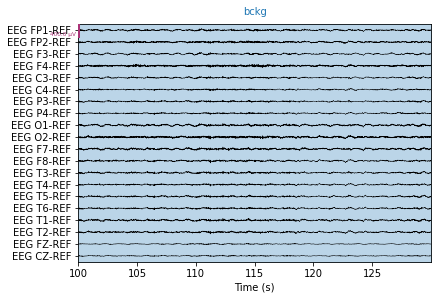

In [30]:
plot_kwargs = {
    'scalings': dict(eeg=20e-5),   # zooms the plot out
    'highpass': 0.5,              # filters out low frequencies
    'lowpass': 70.,                # filters out high frequencies
    'show_scrollbars': False,
    'show': True
}

code_events = events_tse.where(events_tse['Code'] == 'bckg').dropna()
fig = tuh_mne.plot(start = 100, 
                    duration = 30, **plot_kwargs)

fig.savefig('pre.png', dpi=200)
    

Setting up band-pass filter from 0.5 - 70 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 70.00 Hz: -6.02, -6.02 dB



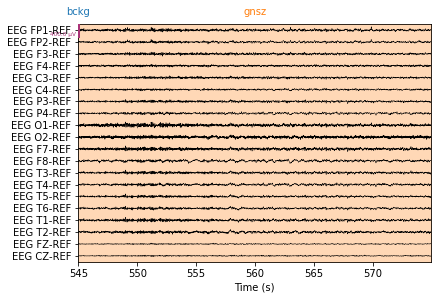

In [33]:
plot_kwargs = {
    'scalings': dict(eeg=20e-5),   # zooms the plot out
    'highpass': 0.5,              # filters out low frequencies
    'lowpass': 70.,                # filters out high frequencies
    'show_scrollbars': False,
    'show': True
}

code_events = events_tse.where(events_tse['Code'] == 'gnsz').dropna()
fig = tuh_mne.plot(start = code_events.sample(random_state = 0)['Start'].values[0], 
                    duration = 30, **plot_kwargs, remove_dc=True)

fig.savefig('ictal.png', dpi=200)
    

Setting up band-pass filter from 0.5 - 70 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 70.00 Hz: -6.02, -6.02 dB



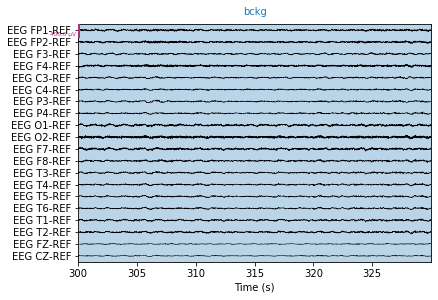

In [32]:
plot_kwargs = {
    'scalings': dict(eeg=20e-5),   # zooms the plot out
    'highpass': 0.5,              # filters out low frequencies
    'lowpass': 70.,                # filters out high frequencies
    'show_scrollbars': False,
    'show': True
}

code_events = events_tse.where(events_tse['Code'] == 'gnsz').dropna()
fig = tuh_mne.plot(start = 300, 
                    duration = 30, **plot_kwargs)

fig.savefig('inter.png', dpi=200)